In [1]:
import numpy as np
import matplotlib.cm as cm
from matplotlib import ticker
import math
import scipy
from scipy import spatial
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import dask
from sklearn.neighbors import KDTree
import netCDF4
from metpy import calc
from metpy.units import units

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
from IPython.display import HTML
from matplotlib import animation
from matplotlib.gridspec import GridSpec

In [2]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw
plt.rc('hatch', color='k', linewidth=1.5)

In [3]:
others = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc")
levs = np.array(others.variables['lev'])
lons = np.array(others.variables['lon'])
new = np.flip(levs)
crms = np.arange(1,129,1)
Xs, Zs = np.meshgrid(crms, new)

In [4]:
def angle_generator(angle):
    R = np.zeros(shape=(2,2))
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R[0,0] = c
    R[0,1] = -s
    R[1,0] = s
    R[1,1] = c
    return R

In [5]:
def array_rotator(array, angle):
    rotated_array = np.empty(array.shape)
    R = angle_generator(angle)
    for i in range(len(array)):
        rotated_array[i, :] =  np.dot(R, array[i,:])  
    
    return rotated_array 

In [6]:
z_test_tsne_track_31_sam = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/latent_space/UM/Big_SAM_Interp_For_UM_2D_PCA_Latent_Space__4503.npy", mmap_mode="r")
z_test_tsne_track_31_sam_origin = np.load('/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/latent_space/UM/Big_SPCAM_Interp_For_UM_2D_PCA_Latent_Space__4503.npy', mmap_mode="r")
z_test_tsne_track_31_IFS = np.load('/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/latent_space/UM/Big_IFS_Interp_For_UM_2D_PCA_Latent_Space__4503.npy', mmap_mode="r")
z_test_tsne_track_31_NICAM = np.load('/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/latent_space/UM/Big_NICAM_Interp_For_UM_2D_PCA_Latent_Space__4503.npy', mmap_mode="r")
z_test_tsne_track_31_SHIELD = np.load('/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/latent_space/UM/Big_SHIELD_Interp_For_UM_2D_PCA_Latent_Space__4503.npy')
z_test_tsne_track_31_ICON = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/latent_space/UM/Big_ICON_Interp_For_UM_2D_PCA_Latent_Space__4503.npy", mmap_mode="r")
z_test_tsne_track_31_ARPEGE = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/latent_space/UM/Big_ARPEGE_Interp_For_UM_2D_PCA_Latent_Space__4503.npy", mmap_mode="r")
z_test_tsne_track_31_GEM = np.load('/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/latent_space/UM/Big_GEM_Interp_For_UM_2D_PCA_Latent_Space__4503.npy')
z_test_tsne_track_31_UM = np.load('/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/latent_space/UM/Big_UM_2D_PCA_Latent_Space__4503.npy')

In [7]:
max_corr = 117
z_test_tsne_track_31_sam  = array_rotator(z_test_tsne_track_31_sam , max_corr)
z_test_tsne_track_31_sam_origin  = array_rotator(z_test_tsne_track_31_sam_origin , max_corr)
z_test_tsne_track_31_IFS  = array_rotator(z_test_tsne_track_31_IFS , max_corr)
z_test_tsne_track_31_NICAM  = array_rotator(z_test_tsne_track_31_NICAM , max_corr)
z_test_tsne_track_31_SHIELD  = array_rotator(z_test_tsne_track_31_SHIELD , max_corr)
z_test_tsne_track_31_ICON  = array_rotator(z_test_tsne_track_31_ICON , max_corr)
z_test_tsne_track_31_ARPEGE  = array_rotator(z_test_tsne_track_31_ARPEGE , max_corr)
z_test_tsne_track_31_GEM  = array_rotator(z_test_tsne_track_31_GEM , max_corr)
z_test_tsne_track_31_UM  = array_rotator(z_test_tsne_track_31_UM , max_corr)

# Cluster (Method 2 -- only do reassignments)

In [9]:
# scaled, saved centers
labels_3_original = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/Scaled_Mandt_Method_Small_SPCAM_To_UM_Interp_Labels_4503_Z_3.npy").astype(int)
labels_3_SAM = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/Scaled_Mandt_Method_Small_SAM_To_UM_Interp_Labels_4503_Z_3.npy").astype(int)
labels_3_UM = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/Small_UM_Labels_4503_Z_3.npy").astype(int)
labels_3_SHIELD = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/Scaled_Mandt_Method_Small_SHIELD_To_UM_Interp_Labels_4503_Z_3.npy").astype(int)
labels_3_ICON = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/Scaled_Mandt_Method_Small_ICON_To_UM_Interp_Labels_4503_Z_3.npy").astype(int)
labels_3_ARPEGE = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/Scaled_Mandt_Method_Small_ARPEGE_To_UM_Interp_Labels_4503_Z_3.npy").astype(int)
labels_3_NICAM = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/Scaled_Mandt_Method_Small_NICAM_To_UM_Interp_Labels_4503_Z_3.npy").astype(int)
labels_3_GEM = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/Scaled_Mandt_Method_Small_GEM_To_UM_Interp_Labels_4503_Z_3.npy").astype(int)
labels_3_IFS = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/Mooers_Logbook/Compressed_Data/Scaled_Mandt_Method_Small_IFS_To_UM_Interp_Labels_4503_Z_3.npy").astype(int)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


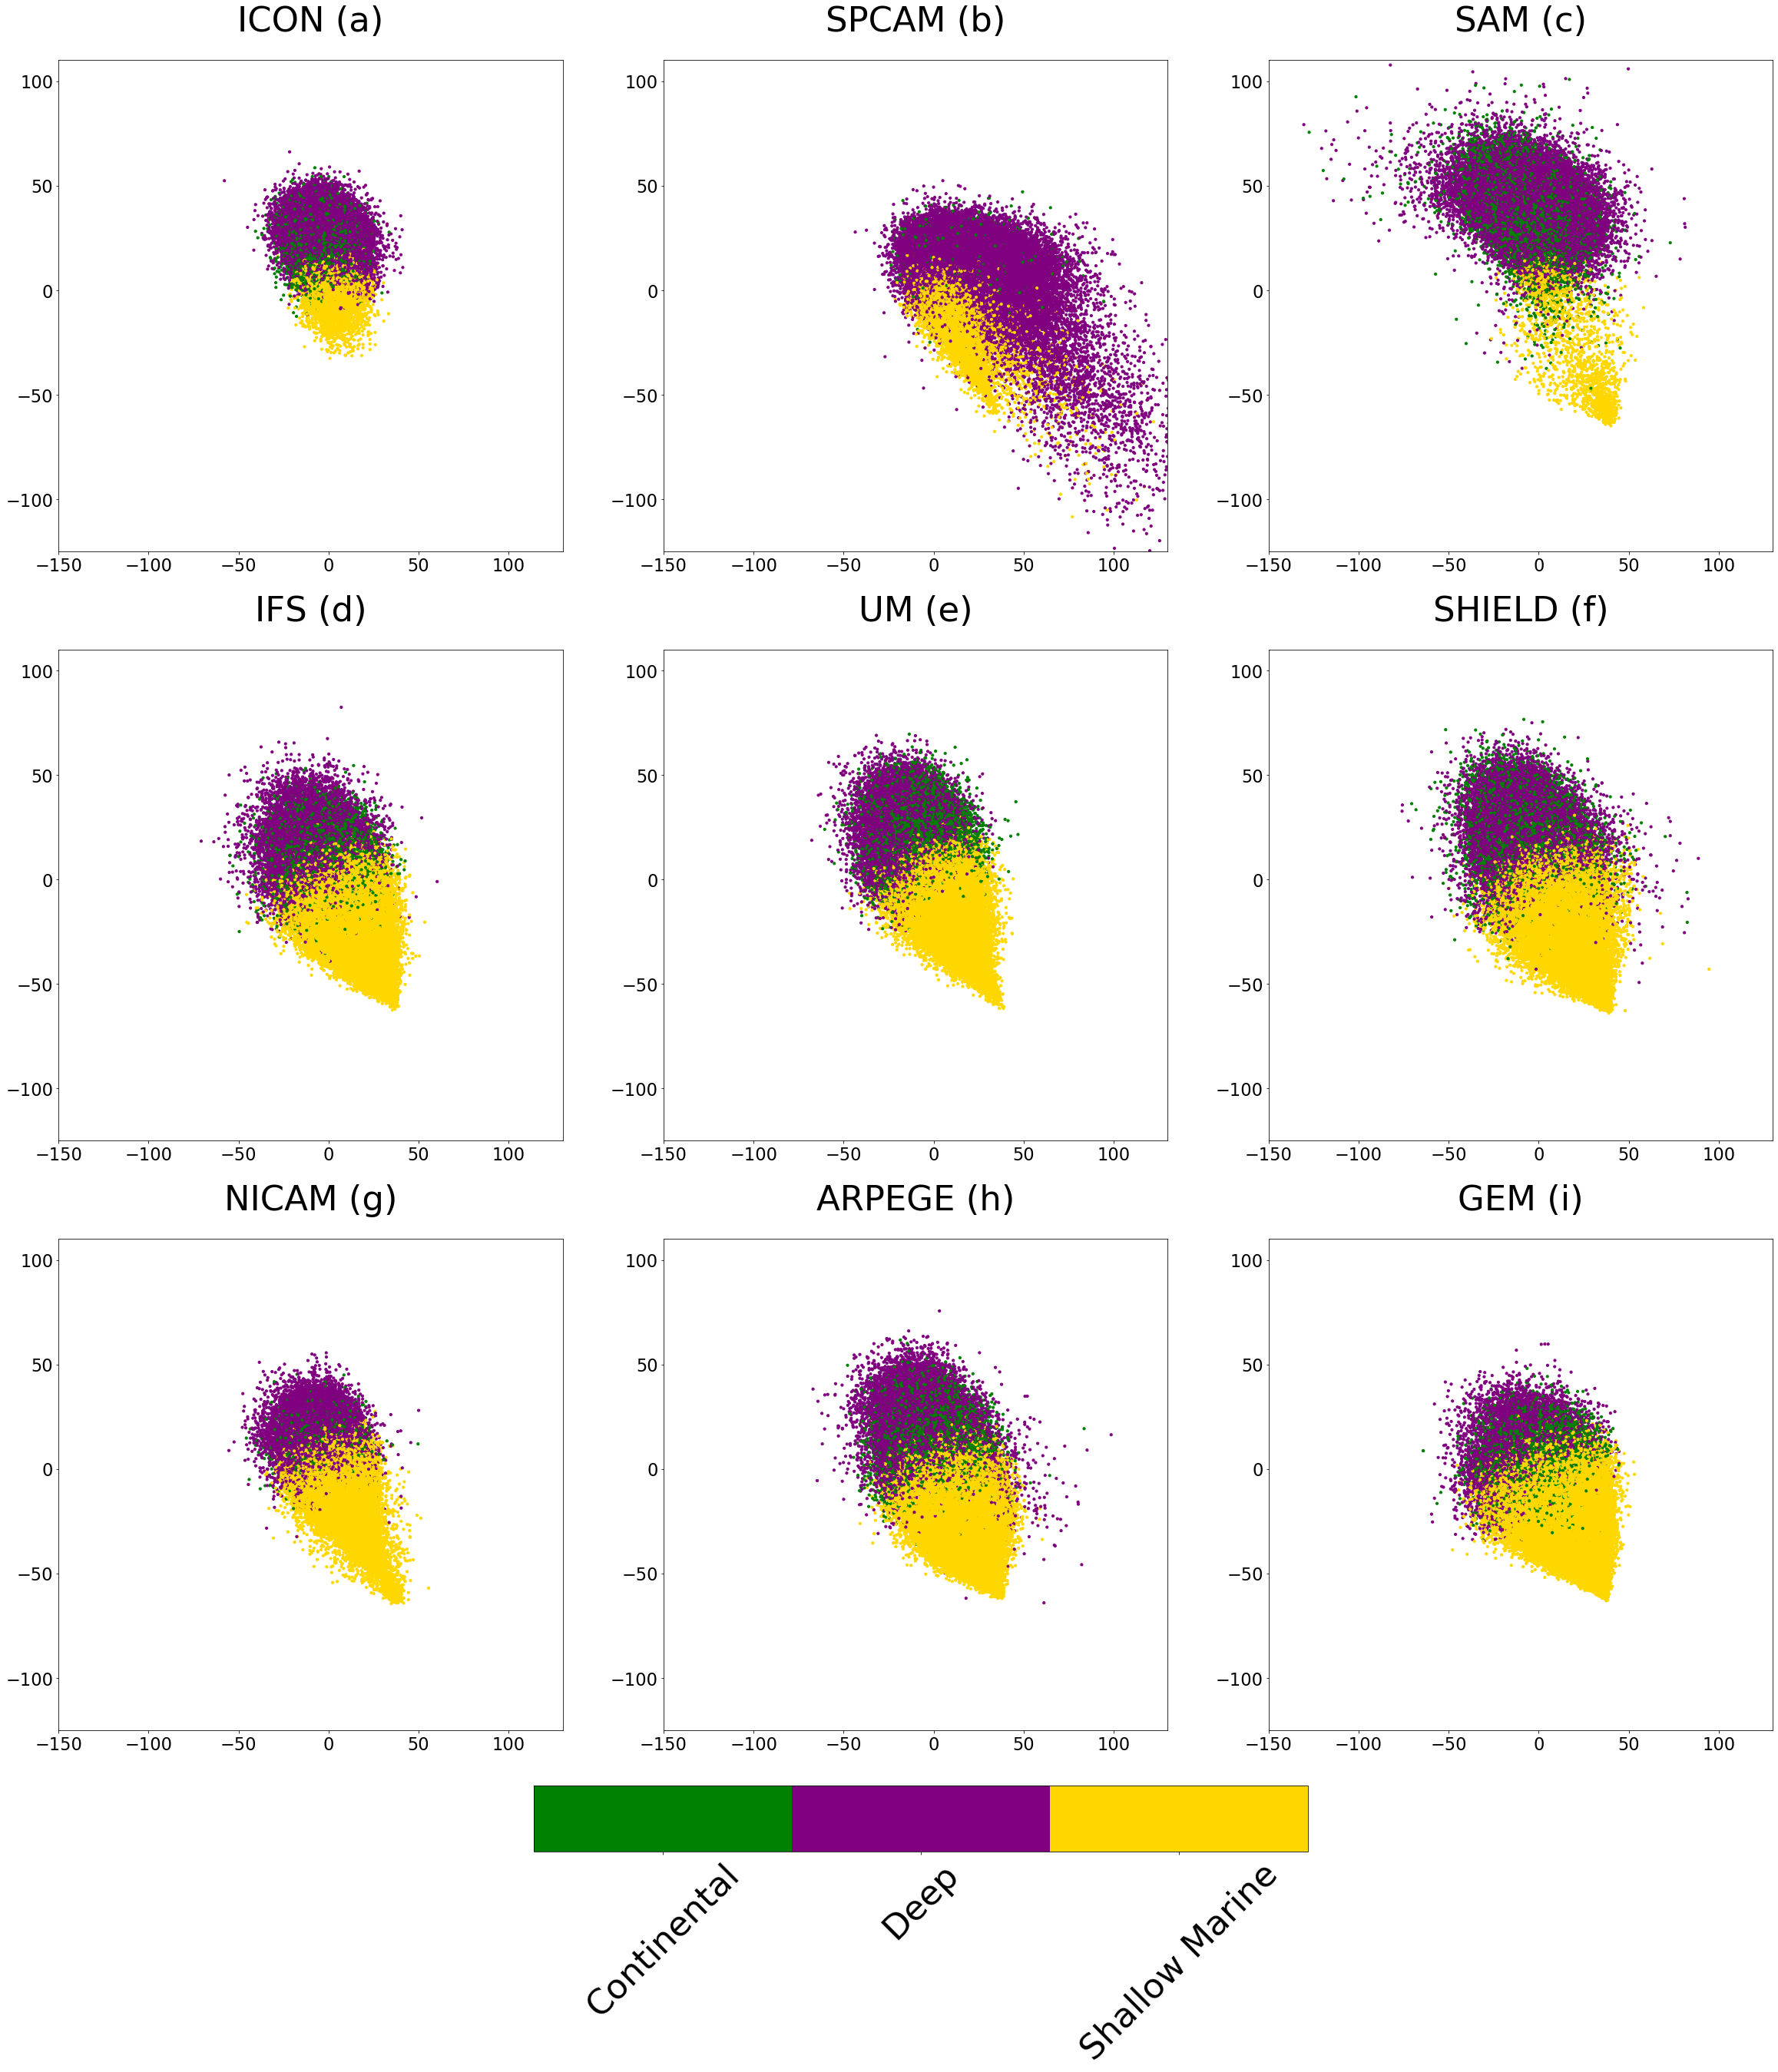

In [10]:
fig, ax = plt.subplots(3,3,figsize=(40,40))
gs=GridSpec(3,3)
cmap = matplotlib.colors.ListedColormap(["green","purple","gold"])

ax1=fig.add_subplot(gs[0,0])

cp = ax1.scatter(x=z_test_tsne_track_31_ICON[:, 0],  y=z_test_tsne_track_31_ICON[:, 1], c=labels_3_ICON, cmap=cmap, s=10.0)
ax1.set_title("ICON (a)", fontsize = fz*2, y = 1.05)

ax1.set_xlim(-150,130)
ax1.set_ylim(-125,110)

ax2=fig.add_subplot(gs[0,1])

cp = ax2.scatter(x=z_test_tsne_track_31_sam_origin[:, 0], y=z_test_tsne_track_31_sam_origin[:, 1], c=labels_3_original, cmap=cmap, s=10.0)
ax2.set_title("SPCAM (b)", fontsize = fz*2, y = 1.05)

ax2.set_xlim(-150,130)
ax2.set_ylim(-125,110)

ax3=fig.add_subplot(gs[0,2])

cp = ax3.scatter(x=z_test_tsne_track_31_sam[:, 0], y=z_test_tsne_track_31_sam[:, 1], c=labels_3_SAM, cmap=cmap, s=10.0)
ax3.set_title("SAM (c)", fontsize = fz*2, y = 1.05)

ax3.set_xlim(-150,130)
ax3.set_ylim(-125,110)

ax4=fig.add_subplot(gs[1,0])

cp = ax4.scatter(x=z_test_tsne_track_31_IFS[:, 0], y=z_test_tsne_track_31_IFS[:, 1], c=labels_3_IFS, cmap=cmap, s=10.0)
ax4.set_title("IFS (d)", fontsize = fz*2, y = 1.05)

ax4.set_xlim(-150,130)
ax4.set_ylim(-125,110)

ax5=fig.add_subplot(gs[1,1])

cp = ax5.scatter(x=z_test_tsne_track_31_UM[:, 0], y=z_test_tsne_track_31_UM[:, 1], c=labels_3_UM, cmap=cmap, s=10.0)
ax5.set_title("UM (e)", fontsize = fz*2, y = 1.05)

ax5.set_xlim(-150,130)
ax5.set_ylim(-125,110)

ax6=fig.add_subplot(gs[1,2])

cp = ax6.scatter(x=z_test_tsne_track_31_SHIELD[:, 0], y=z_test_tsne_track_31_SHIELD[:, 1], c=labels_3_SHIELD, cmap=cmap, s=10.0)
ax6.set_title("SHIELD (f)", fontsize = fz*2, y = 1.05)

ax6.set_xlim(-150,130)
ax6.set_ylim(-125,110)

ax7=fig.add_subplot(gs[2,0])

cp = ax7.scatter(x=z_test_tsne_track_31_NICAM[:, 0], y=z_test_tsne_track_31_NICAM[:, 1], c=labels_3_NICAM, cmap=cmap, s=10.0)
ax7.set_title("NICAM (g)", fontsize = fz*2, y = 1.05)

ax7.set_xlim(-150,130)
ax7.set_ylim(-125,110)

ax8=fig.add_subplot(gs[2,1])

cp = ax8.scatter(x=z_test_tsne_track_31_ARPEGE[:, 0], y=z_test_tsne_track_31_ARPEGE[:, 1], c=labels_3_ARPEGE, cmap=cmap, s=10.0)
ax8.set_title("ARPEGE (h)", fontsize = fz*2, y = 1.05)

ax8.set_xlim(-150,130)
ax8.set_ylim(-125,110)

ax9=fig.add_subplot(gs[2,2])

cp = ax9.scatter(x=z_test_tsne_track_31_GEM[:, 0], y=z_test_tsne_track_31_GEM[:, 1], c=labels_3_GEM, cmap=cmap, s=10.0)
ax9.set_title("GEM (i)", fontsize = fz*2, y = 1.05)

ax9.set_xlim(-150,130)
ax9.set_ylim(-125,110)

cbar_ax = fig.add_axes([0.34, 0.07, 0.35, 0.03])
cbar = fig.colorbar(cp, orientation='horizontal', cax=cbar_ax)

n_clusters=3
tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
cbar.set_ticks(tick_locs)

cbar.ax.set_xticklabels(["Continental","Deep","Shallow Marine"], fontsize=fz*2, rotation=45)

fig.delaxes(ax[0,0])
fig.delaxes(ax[0,1])
fig.delaxes(ax[0,2])
fig.delaxes(ax[1,0])
fig.delaxes(ax[1,1])
fig.delaxes(ax[1,2])
fig.delaxes(ax[2,0])
fig.delaxes(ax[2,1])
fig.delaxes(ax[2,2])

#plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.savefig("../Figures/PNAS_Figure_2.png", bbox_inches='tight', pad_inches = 0.1)
